# AI534 Implementation 1###
**Deadline**: Sunday, Oct. 15, by 11:59pm

**Submission**: Submit 1) your completed notebook in ipynb format, and 2) a PDF export of the completed notebook with outputs.

**Late Submission**: Please see the syllabus for the late submission policy.

In this assignment, we will implement and experiment linear regression to predict the price of a house based on features describing the house, using the housing data that you have explored in the warm up assignment.

We will implement two versions, one using the closed-form solution, and one using gradient descent.

You may modify the starter code as you see fit, including changing the signatures of functions and adding/removing helper functions. However, please make sure that your TA can understand what you are doing and why.

First lets import the necessary packages.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Part 0: (5 pts) data and preprocessing

---

On canvas, we have provided two different data files for this assignment: ia1_train.csv (for training) and ia1_val.csv(for validation). Download them and upload them to your google drive. Then mount the google drive from your google colab notebook:


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

train_path = '/content/gdrive/My Drive/AI534/ia1_train.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
val_path = '/content/gdrive/My Drive/AI534/ia1_val.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Now load the training and validation data.

In [ ]:
#loading the training data and validation data
train = pd.read_csv(train_path)
val = pd.read_csv(val_path)



Perform the following preprocessing steps.
1. remove the *ID* column from both training and validation data
2. change *date* into 3 numerical features *day*, *month* and *year*, like in the warm up exercise
3. The feature *yr_renovated* is set to 0 if the house has not been renovated. This creates an inconsistent meaning to the numerical values. Replace it with a new feature called *age_since_renovated*:

>if *yr_renovate* != 0
>> *age_since_renovated* = *year* - *yr\_renovated*  

>otherwise
>> *age\_since\_renovated = year - yr\_built*

4. Normalize all the feautres using z-score normalization based on the training data. Do not normalize *price* as it is the target.
To normalize a feature *x* using z-score normalization, the fomula is

>$z=\frac{x-\mu}{\sigma}$

where $\mu$ and $\sigma$ are the mean and standard deviation of $x$ respectively. The normalized feature will have zero mean and unit standard deviation. Note that you should estimate $\mu$ and $\sigma$ for each feature only using the training data and use the same $\mu$ and $\sigma$ to normalize the features for both training and validation data.




In [ ]:
#dropping the ID feature from both training and validation data
train_without_id = train.drop(columns=["id"])
val_without_id = val.drop(columns=["id"])

#Splitting the date feature into day, date and month features

train_without_id['date']=pd.to_datetime(train_without_id['date'], format='%m/%d/%Y')
train_without_id['day'] = train_without_id['date'].dt.day
train_without_id['month'] = train_without_id['date'].dt.month
train_without_id['year'] = train_without_id['date'].dt.year
train_without_id=train_without_id.drop(columns=['date'])
train_without_id.dtypes

val_without_id['date']=pd.to_datetime(val_without_id['date'], format='%m/%d/%Y')
val_without_id['day'] = val_without_id['date'].dt.day
val_without_id['month'] = val_without_id['date'].dt.month
val_without_id['year'] = val_without_id['date'].dt.year
val_without_id=val_without_id.drop(columns=['date'])
val_without_id.dtypes

#Converting the yr_renovated feature into age_since renovated feature
temp_df1 = []
for record in train_without_id.itertuples():
    if record.yr_renovated > 0:
      temp_df1.append(record.year - record.yr_renovated)
    else:
      temp_df1.append(record.year - record.yr_built)

train_without_id['age_since_renovated'] = temp_df1
train_without_id = train_without_id.drop(columns=["yr_renovated"])

temp_df2 = []
for record in val_without_id.itertuples():
    if record.yr_renovated > 0:
      temp_df2.append(record.year - record.yr_renovated)
    else:
      temp_df2.append(record.year - record.yr_built)

val_without_id['age_since_renovated'] = temp_df2
val_without_id = val_without_id.drop(columns=["yr_renovated"])

# List of columns to normalize (excluding 'waterfront' and 'price')
columns_to_normalize = [col for col in train_without_id.columns if col not in ['waterfront', 'price']]

# Calculate the mean and standard deviation for each feature in the training data
means = train_without_id[columns_to_normalize].mean()
stds = train_without_id[columns_to_normalize].std()
numerator_train = (train_without_id[columns_to_normalize] - means)

# Apply z-score normalization to the selected columns
train_without_id[columns_to_normalize] = numerator_train / stds
val_without_id[columns_to_normalize] = (val_without_id[columns_to_normalize] - means) / stds

# creating sets for part 3b
train_3b = train_without_id
val_3b = val_without_id

#code to save means and std for future usage if needed
# means.to_csv('feature_means.csv', index=True)
# stds.to_csv('feature_stds.csv', index=True)

#Displaying the outputs after preprocessing
print("Training data after preprocessing")
display(train_without_id)

print("Validation data after preprocessing")
display(val_without_id)

Training data after preprocessing


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,zipcode,lat,long,sqft_living15,sqft_lot15,price,day,month,year,age_since_renovated
0,-0.388520,-1.465613,-1.159110,-0.171139,-0.922332,0,-0.304487,-0.634184,-0.563015,-0.924206,...,0.512279,-0.308988,-0.932779,-1.018504,-0.185644,2.1800,0.600423,-0.513736,-0.682211,0.587803
1,-0.388520,0.169158,0.145003,-0.168133,0.917732,0,-0.304487,0.888924,0.290361,0.507090,...,-1.040633,-1.816632,-1.179633,0.004058,-0.162508,2.5025,-0.793714,-0.193377,-0.682211,0.137857
2,0.649956,0.496112,0.298428,-0.219787,0.917732,0,-0.304487,-0.634184,0.290361,0.675478,...,-0.685148,-1.521596,0.428443,1.494077,-0.238313,2.7000,0.251889,-1.474814,1.465639,-1.004315
3,-0.388520,-0.811705,-0.457738,-0.244481,0.917732,0,-0.304487,-0.634184,0.290361,-0.154433,...,0.755506,0.540053,-1.017415,-0.434182,-0.298603,9.2630,0.716601,-0.513736,-0.682211,2.283754
4,-0.388520,0.496112,0.364182,-0.122419,0.917732,0,-0.304487,0.888924,1.997115,0.747644,...,-0.498050,0.943294,0.781091,0.471515,-0.155295,7.0000,-1.258427,0.767701,-0.682211,-0.554368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.649956,-0.484751,-0.085134,-0.183641,-0.922332,0,-0.304487,-0.634184,-0.563015,-0.827984,...,-1.414829,-1.569205,-0.629502,-0.390358,-0.184623,2.6700,1.181313,-1.474814,1.465639,0.380135
7996,0.649956,0.169158,-0.227600,-0.199316,0.917732,0,-0.304487,-0.634184,-0.563015,0.098149,...,-1.414829,-2.040975,-0.601290,-0.492615,-0.212931,2.9900,1.181313,0.767701,-0.682211,-0.796647
7997,-1.426996,-1.465613,-0.918013,-0.227780,-0.922332,0,-0.304487,-0.634184,-0.563015,-0.659596,...,0.437439,0.618681,-0.728243,0.135531,-0.284994,9.0000,0.368067,1.408420,-0.682211,0.657025
7998,-0.388520,-0.811705,-0.874177,-0.308567,-0.002300,0,-0.304487,-0.634184,0.290361,-0.611485,...,0.811635,0.411651,-0.664767,-0.653303,-0.385160,6.8750,-0.212824,1.088060,-0.682211,2.387588


Validation data after preprocessing


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,zipcode,lat,long,sqft_living15,sqft_lot15,price,day,month,year,age_since_renovated
0,0.649956,-1.465613,-0.611163,-0.125186,-0.002300,0,-0.304487,0.888924,-0.563015,-0.322821,...,-0.834826,1.226067,-0.156953,-0.653303,-0.172715,3.8900,-1.142248,0.447342,-0.682211,0.068634
1,-0.388520,0.169158,-0.304313,0.020425,-0.922332,0,-0.304487,-0.634184,0.290361,-0.539319,...,-0.759987,-1.291481,1.204269,0.018666,0.083587,3.3562,0.019532,-1.154455,1.465639,-0.415923
2,-0.388520,-0.811705,-0.326231,-0.239710,-0.922332,0,5.014070,0.888924,-0.563015,-0.912178,...,0.736796,-0.314038,-0.298012,-0.302710,-0.179520,4.2000,-0.445180,1.728779,-0.682211,0.518580
3,-1.426996,-1.465613,-0.918013,-0.206307,-0.922332,0,1.025152,0.888924,-0.563015,-0.876095,...,0.886474,-0.079596,-1.151421,-1.091544,-0.216946,5.5900,0.251889,-0.193377,-0.682211,1.210806
4,-0.388520,0.169158,0.123085,-0.148234,-0.922332,0,-0.304487,-0.634184,-0.563015,-0.479181,...,-1.452249,-2.142687,-0.213377,-0.726343,-0.136445,1.9425,1.646026,1.088060,-0.682211,-0.485146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2.726909,-1.465613,-0.775547,-0.237801,-0.002300,0,-0.304487,-0.634184,-1.416392,-0.803929,...,0.512279,-0.263543,-0.960991,-1.412920,-0.261857,4.1500,0.484245,-1.795174,1.465639,1.487696
1996,-0.388520,-0.484751,-0.753629,-0.182472,-0.922332,0,-0.304487,0.888924,-0.563015,-0.479181,...,-0.890955,-1.024578,0.223907,-0.770167,-0.169312,2.4600,-0.909892,-0.513736,-0.682211,-0.069811
1997,1.688433,1.803929,1.777884,-0.190679,0.917732,0,-0.304487,-0.634184,1.143738,2.299217,...,-0.086435,0.234918,1.105528,1.727805,-0.212625,8.8995,-0.561358,-1.474814,1.465639,-1.385039
1998,-0.388520,0.496112,-0.896095,-0.332712,2.757797,0,-0.304487,-0.634184,0.290361,-0.635541,...,0.530988,0.827155,-1.221951,-0.974679,-0.349639,4.4500,0.948957,1.088060,-0.682211,-1.177371


Let's do a quick testing of your normalization, please
1. Estimate and print the new mean and standard deviation of the normalized features for the training data --- this should be 0 and 1 respectively.  
2. Estimate and print the new mean and standard deviation of the normalized features for the validation data --- these values will not be 0 and 1, but somewhat close

In [ ]:
from tabulate import tabulate
#calculating new Mean and Standard Values after normalized
new_stds_train = train_without_id[columns_to_normalize].std()
new_means_val = val_without_id[columns_to_normalize].mean()
new_stds_val = val_without_id[columns_to_normalize].std()
new_means_train = train_without_id[columns_to_normalize].mean()


print("New Training Mean: \n", new_means_train)
print("\n\nNew Training Standard Deviation: \n", new_stds_train)
print("\n\nNew Validation Mean: \n", new_means_val)
print("\n\nNew Validation Standard Deviation: \n", new_stds_val)

New Training Mean: 
 bedrooms               1.953993e-16
bathrooms             -1.776357e-16
sqft_living            8.704149e-17
sqft_lot              -3.552714e-18
floors                 2.176037e-17
view                   1.953993e-17
condition              1.163514e-16
grade                  8.348877e-17
sqft_above            -1.030287e-16
sqft_basement          7.105427e-18
yr_built               3.389289e-15
zipcode                3.703171e-14
lat                   -4.131273e-14
long                   9.379075e-14
sqft_living15          6.217249e-17
sqft_lot15            -3.552714e-18
day                   -2.919887e-17
month                 -3.419487e-17
year                   1.992757e-13
age_since_renovated   -9.769963e-17
dtype: float64


New Training Standard Deviation: 
 bedrooms               1.0
bathrooms              1.0
sqft_living            1.0
sqft_lot               1.0
floors                 1.0
view                   1.0
condition              1.0
grade             


## ***Question***
Why is it import to use the same $\mu$ and $\sigma$ to perform normalization on the training and validation data? What would happen if we use $\mu$ and $\sigma$ estimated using the validation to perform normalization on the validation data?  


To ensure consistency and improve the generalization of machine learning models, it is imperative to use the same mean (the average value) and standard deviation (a measure of data spread) for feature normalization in both training and validation data. In these two datasets, applying different statistical values for normalization can result in a number of problems. It is visible from above experiments

**1. Inconsistent Scaling:** The training and validation datasets may not scale consistently when different statistics are used for normalization. Because the model was trained on features with different scales, it might have trouble generalizing successfully to the validation data.

**2. Poor Model Performance:** The model may perform poorly on the validation data when features are normalized differently in the training and validation sets. This occurs as a result of the model's ability to predict events using features of a different scale and distribution.

**3. Data Leakage:** The use of the mean and standard deviation calculated from validation data for the normalization of training data raises the issue of "data leakage." This means that the training process is accidentally influenced by the data from the validation or test dataset, which may lead to overly optimistic performance evaluations. It is crucial to keep training data and validation data separate at all times.

# Part 1 (15 pts) Generate closed-form solution for reference.
Our data now contains 21 numeric features, before we learn a linear regression model using gradient descent, we will first build the closed-form solution as a reference point. So for this part, you need to
1. Implement the close-form solution for linear regression and apply it to the training data to learn the weight vector for your linear regression model.
2. Apply your learned linear regression model to the training data to make predictions for all training examples and report the Mean Squared Error.
3. Apply your learned linear regression model to the validation data to make predictions for all the validation examples and report the mean squared error for the validation data.

Your code should print the weight vector, which has 22 dimensions, one for each feature plus one additional $w_0$.  Your code should also report the MSE for the training and validation data respectively.*italicized text*

In [ ]:
temp_t = train_without_id
val_t = val_without_id

# adding a dummy column to ensure the w0 constant in Gradient Descent formula for d+1 dimension
temp_t['dumy'] = 1
val_t['dumy'] = 1

# sepeating dependent and independent variables
X_train = temp_t.drop(columns=['price']).values
y_train = temp_t['price'].values
X_val = val_t.drop(columns=['price']).values
y_val = val_t['price'].values

# Calculate the closed-form solution for linear regression
w = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)

# Make predictions on the training and validation data
y_train_pred = X_train.dot(w)
y_val_pred = X_val.dot(w)

# Calculate the Mean Squared Error for training and validation data
mse_train = ((y_train - y_train_pred) ** 2).mean()
mse_val = ((y_val - y_val_pred) ** 2).mean()


# Print the weight vector and MSE
print("Weights:", w)
print("\nTraining MSE:", mse_train)
print("Validation MSE:", mse_val)


Weights: [ 1.85894829  1.456052   -3.94687804  0.13746009  0.47974482  5.82630342
  0.3369939   0.13050692  0.98650611  0.58013185  1.67741098 -0.88336171
 -0.26341874  0.83661248 -0.30369641  0.14358099 -0.09927428 -0.05063652
  0.05485035  0.17375019 -0.10255779  5.33462373]

Training MSE: 14.398737248152836
Validation MSE: 14.286412531366304


## Question
The learned feature weights are often used  to understand the importance of the features. The sign of the weights indicates if a feature positively or negatively impact the price, and the magnitude suggests the strength of the impact. Does the sign of all the features match your expection based on your common-sense understanding of what makes a house expensive? Please hightlight any surprises from the results.


**Answer:** Usually significance of features can be achieved by looking at learned feature weights in the context of home price prediction. These weights indicate the degree to which a feature affects price, indicating whether it has a favorable or unfavorable effect. These weights typically correspond with what one would expect to see in reality. For instance, as would be expected logically, features like more rooms and appealing views consistently have positive weights.

The analysis brought up two interesting surprises. First, it turns out that older houses are often more expensive than newer ones, which goes against what most people think. This could be because older houses have unique features or historical value. Second, having a larger living space doesn't always mean a higher price. In fact, it can sometimes make the price lower, which is not what we usually expect. These surprises show us that real-world data can be complex and that machine learning can find unexpected patterns. Even though common sense is a good starting point, this shows how powerful machine learning is for understanding data.

# Part 2 (40 pts) Implement and experiment with batch gradient descent

Your implementation should take following inputs:

1. the training data (with $d$ features and 1 target variable $y$),

2. the learning rate $\gamma$,

3. the number of iterations $T$

4. Optional convergence threshold (optional) $\epsilon_l$ for the loss or $\epsilon_g$ for the norm of the gradient

It should output:
1. the learned $d+1$ - dimensional weight vector
2. the sequence of $T$ MSE losses, one for each training epoch. You will be asked to plot the losses as a function of training epoch later.


In [ ]:
from numpy import random

def batch_gd(data, labels, lr, iterations):
    epsilon = 0.001
    N = data.shape[0]
    M = data.shape[1]
    weights = random.rand(M,1)
    losses = []
    labels = labels.to_numpy()
    labels = labels.reshape((len(labels),1))
    for i in range(iterations):
        error = data@weights - labels
        Loss = (1/N)*((np.linalg.norm(error))**2)
        a = 2*np.transpose(data)@(data@weights - labels)
        a = a.to_numpy()
        losses.append(Loss)
        grad_L = (1/N)*(a)
        weights = weights - lr*grad_L
        if (np.linalg.norm(error)<= epsilon):
            break
    return weights, losses

You will now experiment with the batch gradient descent algorithm with different learning rate on the provided data.

Please train your model for up to 3000 iterations using different learning rate: $\gamma=10^{-i}$, $i=0,1,...,4$. For each learning rate, you can opt to stop early if it has converged (using the convergence threshold) or diverged (the loss start to grow larger).

For each converging (not necessarily converged yet) learning rate, please compute and report the MSE of the final learned weights on the validation data.

Also please provide a plot that shows the training loss curves (MSE as a function of the # of epochs) for all the converging learning rates. Please use different colors mark different learning rates and provide proper legends for your figure.


Validation Data:  MSE LR for i=1  4.508131725083911
Train Data:  MSE LR for i=1  3.757949442944492
Validation Data:  MSE LR for i=2  4.625903788597894
Train Data:  MSE LR for i=2  3.7835838250362994
Validation Data:  MSE LR for i=3  4.779483130127881
Train Data:  MSE LR for i=3  3.8848597838667467
Validation Data: MSE LR for i=4  12.663499187097598
Train Data:  MSE LR for i=4  11.213638590569465


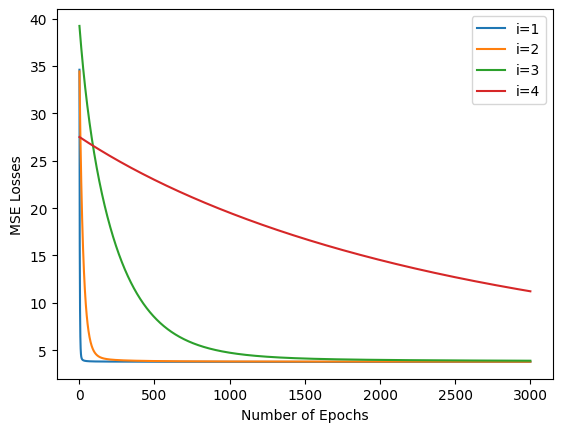

In [ ]:

Xnew_train_bgd_np = train_without_id.drop(columns=['price']).values
Xnew_train_bgd = pd.DataFrame(Xnew_train_bgd_np)

labels_train = train["price"]
Xnew_val_bgd = val_without_id.drop(columns=['price']).values
labels_val = val["price"]

#defining the learning rates
lr0, lr1, lr2, lr3, lr4 = 1, 0.1, 0.01, 0.001, 0.0001

# weights_bgd0, losses0 = batch_gd(Xnew_train_bgd, labels_train, lr0, 3000)
# y_val_pred_bgd0 = Xnew_val_bgd @ weights_bgd0
# y_val_pred_bgd0_df = pd.DataFrame(y_val_pred_bgd0)
# mse_val_bgd0 = mean_squared_error(labels_val, y_val_pred_bgd0_df)
# print(" MSE LR for i=0 ", mse_val_bgd0)

# Training using the batch gradient descent
weights_bgd1, losses1 = batch_gd(Xnew_train_bgd, labels_train, lr1, 3000)
weights_bgd2, losses2 = batch_gd(Xnew_train_bgd, labels_train, lr2, 3000)
weights_bgd3, losses3 = batch_gd(Xnew_train_bgd, labels_train, lr3, 3000)
weights_bgd4, losses4 = batch_gd(Xnew_train_bgd, labels_train, lr4, 3000)

#calculating and printing the new MSE
y_val_pred_bgd1 = Xnew_val_bgd @ weights_bgd1
y_val_pred_bgd1_df = pd.DataFrame(y_val_pred_bgd1)
mse_val_bgd1 = mean_squared_error(labels_val, y_val_pred_bgd1_df)
print("Validation Data:  MSE LR for i=1 ", mse_val_bgd1)

y_train_pred_bgd1 = Xnew_train_bgd @ weights_bgd1
y_train_pred_bgd1_df = pd.DataFrame(y_train_pred_bgd1)
mse_train_bgd1 = mean_squared_error(labels_train, y_train_pred_bgd1_df)
print("Train Data:  MSE LR for i=1 ", mse_train_bgd1)

y_val_pred_bgd2 = Xnew_val_bgd @ weights_bgd2
y_val_pred_bgd2_df = pd.DataFrame(y_val_pred_bgd2)
mse_val_bgd2 = mean_squared_error(labels_val, y_val_pred_bgd2_df)
print("Validation Data:  MSE LR for i=2 ", mse_val_bgd2)

y_train_pred_bgd2 = Xnew_train_bgd @ weights_bgd2
y_train_pred_bgd2_df = pd.DataFrame(y_train_pred_bgd2)
mse_train_bgd2 = mean_squared_error(labels_train, y_train_pred_bgd2_df)
print("Train Data:  MSE LR for i=2 ", mse_train_bgd2)

y_val_pred_bgd3 = Xnew_val_bgd @ weights_bgd3
y_val_pred_bgd3_df = pd.DataFrame(y_val_pred_bgd3)
mse_val_bgd3 = mean_squared_error(labels_val, y_val_pred_bgd3_df)
print("Validation Data:  MSE LR for i=3 ", mse_val_bgd3)

y_train_pred_bgd3 = Xnew_train_bgd @ weights_bgd3
y_train_pred_bgd3_df = pd.DataFrame(y_train_pred_bgd3)
mse_train_bgd3 = mean_squared_error(labels_train, y_train_pred_bgd3_df)
print("Train Data:  MSE LR for i=3 ", mse_train_bgd3)

y_val_pred_bgd4 = Xnew_val_bgd @ weights_bgd4
y_val_pred_bgd4_df = pd.DataFrame(y_val_pred_bgd4)
mse_val_bgd4 = mean_squared_error(labels_val, y_val_pred_bgd4_df)
print("Validation Data: MSE LR for i=4 ", mse_val_bgd4)

y_train_pred_bgd4 = Xnew_train_bgd @ weights_bgd4
y_train_pred_bgd4_df = pd.DataFrame(y_train_pred_bgd4)
mse_train_bgd4 = mean_squared_error(labels_train, y_train_pred_bgd4_df)
print("Train Data:  MSE LR for i=4 ", mse_train_bgd4)

#Plotting MSE vs Epochs

ep = [i for i in range(1, 3001)]

# Naming the axis
plt.xlabel("Number of Epochs")
plt.ylabel("MSE Losses")

#creating the plots
plt.plot(ep, losses1, label='i=1')
plt.plot(ep, losses2, label='i=2')
plt.plot(ep, losses3, label='i=3')
plt.plot(ep, losses4, label='i=4')

plt.legend()
plt.show()


## Question

Which learning rate leads to the best trainng and validation MSE respectively? Do you observe better training MSE tend to correpsond to better validation MSE? How is this different from the trend shown in slide 43 (titled danger of using training loss to select M) discussed in class regarding overfitting? Is there any issue with using training loss to pick learning rate in this case?

**Answer:** The lowest Mean Squared Error (MSE), for both training and validation datasets, is produced by a learning rate of 0.1 (i.e., LR = 0.1), according to observations for the best learning rate. This shows that the model performs best in terms of MSE on both the data it was trained on and new, unseen data when the learning rate is set to 0.1 during the training process. This result suggests that the selected learning rate is appropriate for the particular model and dataset and strikes a good balance between underfitting and overfitting.

Positive trend exists between higher training MSE and higher validation MSE. Improvements in training performance indicate an overall improvement in model performance, indicating that the model generalizes well to new data. In machine learning, this alignment is a desired result because it shows that the model isn't overfitting the training data.

This scenario, however, is distinct from the overfitting scenario depicted in slide 43 ("danger of using training loss to select M") that was discussed in class. In that slide, the validation loss begins to increase after initially being very similar to the training loss. This phenomenon shows that the model starts to overfit as it learns and improves its performance on the training data, which lowers its performance on the validation data. This emphasizes the danger of choosing model parameters solely based on training loss. Here based on our experimented LR's it is not visible and holds not true.

Lower MSE values for the training and validation datasets as a result of the chosen learning rate, LR = 0.1, show effective generalization. Therefore, choosing the learning rate based primarily on the training loss seems like a wise decision in this particular situation. It's important to stress that these results might not be applicable to all datasets and models. To make sure that the model is properly tuned and resistant to overfitting, it is still critical to use supplemental techniques like cross-validation and ongoing monitoring of the validation loss. Additionally, the ideal learning rate can change depending on the features of the dataset and the particulars of the issue being solved.

# Part 3. More exploration.

## **3(a). (20 pts) Normalization of features: what is the impact?**
In part 1, you were asked to perform z-score normalization of all the features. In this part, we will ask you to first conceptually think about what is the impact this operation on the solution and then use some experiments to varify your conceptual understanding.

### **Questions.**

The normalization process applies a linear transformation to each feature, where the transformed feature $x'$ is simply a linear function of original feature $x$: $x'=\frac{x-\mu}{\sigma}$.

Let's disect the influence of this transformation on our learned linear regression model.
1. How do you think this transformation will influnce the training and validation MSE we get for the closed-form solution? Why?
2. How do you think this will change the magnitude of the weights of the learned model? Why?
3. How do you think this will change the convergence behavior of the batch gradient descent algorithm? Why?

**Answer:** Normalization using zscore can help to provide positive influence over lower MSE on both sets as data is adjusted in a similar scale. Also, using this helps achieve faster convergence and outputs an improved generalization. It plays a pivotal role in balancing feature scales, enhancing convergence speed, improving generalization, and making your model more interpretable and robust. The combined impact of these advantages is bound to elevate the performance and reliability of your predictive models.

The learned model's weights will have a different magnitude after normalization. The weights will be affected by the scaling of features when they are centered around their mean and scaled by a factor (). The correlation between the normalized features and the target variable will be reflected in the weights. In particular, weights will have a magnitude based on the effect of the corresponding feature on the target variable. Normalization scales down the feature, but the weight continues to signify the strength of the connection.

Normalization plays a crucial role in enhancing the convergence process of Batch Gradient Descent in several key ways. To begin, it promotes a stable learning rate, which is vital for the success of Gradient Descent techniques, including Batch Gradient Descent. Normalization ensures that the learning rate remains consistent across various features, thus preventing the algorithm from making abrupt and erratic moves, ultimately leading to faster convergence. Additionally, normalization reduces the algorithm's sensitivity to the initial weight values. This means that the optimization process becomes less prone to getting stuck in local minimum points, resulting in a more efficient and dependable convergence process.


Now please perform the following experiments to verify your answer to the above questions.
1. Apply closed-form solution to data that did not go through the feature normalization step, and report the learned weights and the resulting training and testing MSEs.
2. Apply gradient descent algorithm to data that did not go through the feature normalization step using different learning rate. Note that the learning rate used in previous section will no longer work here. You will need to search for an appropriate learning rate to get convergence. (Hint: this needs to be much much smaller than what was used in part 2). Plot your MSE loss curve as a function of the epochs once you identify a convergent learning rate.

using CLosed form
Weights: [-1.56580141e+00  3.42981773e+00  3.06515349e-01  6.35997910e-07
 -6.19896966e+00  1.60718549e+02 -9.59211186e+00 -3.54895474e+00
  3.72208161e+00 -3.03731351e-01 -3.02425054e-01 -2.99656211e-02
 -4.92850759e-03  6.03499297e+00 -2.14196020e+00  2.09743484e-04
 -3.37769944e-06 -5.88285401e-03  1.75718219e-02  3.73189368e-01
 -3.54965384e-03 -7.64958208e+02]
Training MSE: 172.6628312733273
Validation MSE: 192.5086270948539

 using batch gradient descent 
Training Data:  MSE LR for i= 0.0000000001 3.817330888291525e+83
Validation Data:  MSE LR for i= 0.0000000001 3.804092979348109e+83


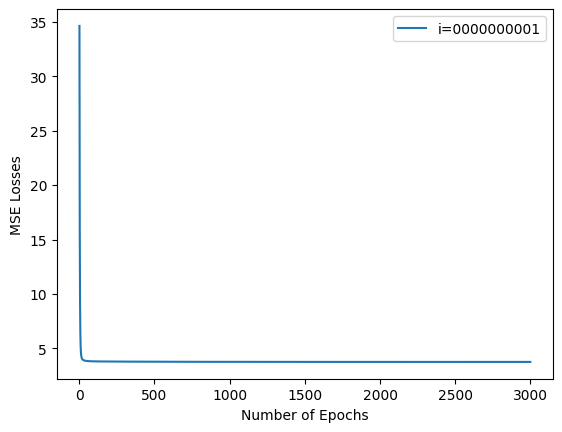

In [ ]:
# applying closed form solution to the non normalized data

#loading the data
train_nn = pd.read_csv(train_path)
val_nn = pd.read_csv(val_path)

#prepocessing steps as before
train_nn_wi = train_nn.drop(columns=["id"])
val_nn_wi = val_nn.drop(columns=["id"])

train_nn_wi['date']=pd.to_datetime(train_nn_wi['date'], format='%m/%d/%Y')
train_nn_wi['day'] = train_nn_wi['date'].dt.day
train_nn_wi['month'] = train_nn_wi['date'].dt.month
train_nn_wi['year'] = train_nn_wi['date'].dt.year
train_nn_wi=train_nn_wi.drop(columns=['date'])

val_nn_wi['date']=pd.to_datetime(val_nn_wi['date'], format='%m/%d/%Y')
val_nn_wi['day'] = val_nn_wi['date'].dt.day
val_nn_wi['month'] = val_nn_wi['date'].dt.month
val_nn_wi['year'] = val_nn_wi['date'].dt.year
val_nn_wi=val_nn_wi.drop(columns=['date'])


#calculating age
temp_df3 = []
for record in train_nn_wi.itertuples():
    if record.yr_renovated > 0:
      temp_df3.append(record.year - record.yr_renovated)
    else:
      temp_df3.append(record.year - record.yr_built)

train_nn_wi['age_since_renovated'] = temp_df3
train_nn_wi = train_nn_wi.drop(columns=["yr_renovated"])
train_nn_wi.dtypes

temp_df4 = []
for record in val_nn_wi.itertuples():
    if record.yr_renovated > 0:
      temp_df4.append(record.year - record.yr_renovated)
    else:
      temp_df4.append(record.year - record.yr_built)

val_nn_wi['age_since_renovated'] = temp_df4
val_nn_wi = val_nn_wi.drop(columns=["yr_renovated"])
val_nn_wi.dtypes

#temp dataframes
temp_t_nn = train_nn_wi
val_t_nn = val_nn_wi

#adding dummy for coeficient w0
temp_t_nn['dumy'] = 1
val_t_nn['dumy'] = 1

#seperating dependent and label feature
X_train_nn = temp_t_nn.drop(columns=['price']).values
y_train_nn = temp_t_nn['price'].values
X_val_nn = val_t_nn.drop(columns=['price']).values
y_val_nn = val_t_nn['price'].values

# Calculate the closed-form solution for linear regression
w_nn = np.linalg.inv(X_train_nn.T.dot(X_train_nn)).dot(X_train_nn.T).dot(y_train_nn)

# Make predictions on the training and validation data
y_train_pred_nn = X_train_nn.dot(w_nn)
y_val_pred_nn = X_val_nn.dot(w_nn)

# Calculate the Mean Squared Error for training and validation data
mse_train_nn = ((y_train_nn - y_train_pred_nn) ** 2).mean()
mse_val_nn = ((y_val_nn - y_val_pred_nn) ** 2).mean()

# Print the weight vector and MSE using closed form

print("using CLosed form")
print("Weights:", w_nn)
print("Training MSE:", mse_train_nn)
print("Validation MSE:", mse_val_nn)

X_train_nn1 = pd.DataFrame(X_train_nn)

y_train_nn1 = pd.DataFrame(y_train_nn)

#applyting batch gradient descent
weights_nn_bgd, losses_nn = batch_gd(X_train_nn1, y_train_nn1, 0.0000000001, 3000)

y_val_pred_bgd_nn = X_val_nn @ weights_nn_bgd
y_val_pred_bgd_nn_df = pd.DataFrame(y_val_pred_bgd_nn)
mse_val_bgd_nn = mean_squared_error(y_val_nn, y_val_pred_bgd_nn_df)

y_train_pred_bgd_nn = X_train_nn1 @ weights_nn_bgd
y_train_pred_bgd_nn_df = pd.DataFrame(y_train_pred_bgd_nn)
mse_train_bgd_nn = mean_squared_error(y_train_nn, y_train_pred_bgd_nn_df)


print("\n using batch gradient descent ")
print("Training Data:  MSE LR for i= 0.0000000001", mse_train_bgd_nn)
print("Validation Data:  MSE LR for i= 0.0000000001", mse_val_bgd_nn)

#Plotting MSE vs Epochs

ep = [i for i in range(1, 3001)]

# Naming the axis
plt.xlabel("Number of Epochs")
plt.ylabel("MSE Losses")

#creating the plots
plt.plot(ep, losses1, label='i=0000000001')

plt.legend()
plt.show()

**Questions**

Please revisit the questions above. Does your experiment confirm your expectation?  Can you provide explanations to the observed differences (or lack of differences) between the normalized data and unnormalized data? Based on these observations and your understanding of them, please comment on the benefits of normalizing the input features in learning for linear regressions.


**Answer** In the experiment, I was quite surprised by the results when I looked at how data normalization affected our outcomes. Initially, I thought that using a method like z-scores to normalize the data would lead to a decrease in the Mean Squared Error (MSE) for both my training and validation sets. I also believed it would help my model learn faster and become more accurate in making predictions. My idea is validated here with the expectation as MSE of training increased from 14.39 to 172.66 and MSE of validation is increased to 14.28 to 192.508 which conforms the assumption that normalization helps reduce the MSE. Additionally, the weights of my model became smaller after normalization, which is something I anticipated as a result of feature scaling. But what really surprised me was that my model didn't seem to learn any faster, as I had hoped it would. These findings highlight the importance of considering the specific characteristics of the data and the choice of normalization techniques, as they can have unexpected effects on the model's performance.

## **3(b). (20 pts) explore the impact of redundant features**

In the warm up exercise, you all have seen some features are highly correlated with one another. For example, there are multiple squared footage related features that are strongly correlated (e.g., *sqft_above* and *sqrt_living* has a correlation coefficient of 0.878).  This is referred to as multicollinearity phenomeon, where two or more features are correlated.

There are numerous consequences from multicollinearity. It makes it more challenging to estimate the weights of the features accurately. The weights may become unstable, and their interpretation becomes less clear.

In this part you will start with the pre-processed training set, and perform the following experiments **using the closed-form solution**.
Specifically, your code should:
1. randomly subsample 75% percent of the training data (with normalized features) for five times
2. creating five slighly different training sets that are 75% of the original training set size.
3. for each such training set, perform learning using the closed-form solution and report the learned weight vector in a table, where you can show each weight vector solution as a row (or column in the table), and include a header for your table to indicate the corresponding feature name for each weight coefficient.

In [ ]:
# Create a random subsample of 75 percent of the rows
sample_size = int(0.75 * len(train_3b))

train_ss1 = train_3b.sample(n=sample_size, random_state=42)
train_ss2 = train_3b.sample(n=sample_size, random_state=39)
train_ss3 = train_3b.sample(n=sample_size, random_state=5)
train_ss4 = train_3b.sample(n=sample_size, random_state=128)
train_ss5 = train_3b.sample(n=sample_size, random_state=79)

# creating the dataset for learning with closed form for all the subsamples

X_train_ss1 = train_ss1.drop(columns=['price']).values
y_train_ss1 = train_ss1['price'].values

X_train_ss2 = train_ss2.drop(columns=['price']).values
y_train_ss2 = train_ss2['price'].values

X_train_ss3 = train_ss3.drop(columns=['price']).values
y_train_ss3 = train_ss3['price'].values

X_train_ss4 = train_ss4.drop(columns=['price']).values
y_train_ss4 = train_ss4['price'].values

X_train_ss5 = train_ss5.drop(columns=['price']).values
y_train_ss5 = train_ss5['price'].values

#learning using closed form solutoion for the given subsamples
w_ss1 = np.linalg.inv(X_train_ss1.T.dot(X_train_ss1)).dot(X_train_ss1.T).dot(y_train_ss1)
w_ss2 = np.linalg.inv(X_train_ss2.T.dot(X_train_ss2)).dot(X_train_ss2.T).dot(y_train_ss2)
w_ss3 = np.linalg.inv(X_train_ss3.T.dot(X_train_ss3)).dot(X_train_ss3.T).dot(y_train_ss3)
w_ss4 = np.linalg.inv(X_train_ss4.T.dot(X_train_ss4)).dot(X_train_ss4.T).dot(y_train_ss4)
w_ss5 = np.linalg.inv(X_train_ss5.T.dot(X_train_ss5)).dot(X_train_ss5.T).dot(y_train_ss5)

#printing as a table
feature_names = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
    'waterfront', 'view', 'condition', 'grade', 'sqft_above',
    'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long',
    'sqft_living15', 'sqft_lot15', 'day', 'month', 'year',
    'age_since_renovated', "dummy"
]

data = {
    'Features': feature_names,
    'Subsample 1': w_ss1,
    'Subsample 2': w_ss2,
    'Subsample 3': w_ss3,
    'Subsample 4': w_ss4,
    'Subsample 5': w_ss5
}

# Convert the data dictionary into a DataFrame
result_table = pd.DataFrame(data)
table_title = 'Weights Calculated for features in different Subsamples'
# Print the table
table = result_table.to_string(index=False)
print(table_title)
print(table)

Weights Calculated for features in different Subsamples
           Features  Subsample 1  Subsample 2  Subsample 3  Subsample 4  Subsample 5
           bedrooms    -0.443681     0.064407    -1.910217    -0.473388    -0.578464
          bathrooms     0.989405    -0.058691    -1.677813     0.103181     0.700480
        sqft_living     0.885414     2.577881    12.532605     3.585770     0.565411
           sqft_lot     0.042546     0.089438     0.080671     0.093658     0.013916
             floors     0.036898     0.175375     0.223782    -0.092950     0.158451
         waterfront     3.859393     3.076433     9.835037     5.914334     3.505996
               view     0.478477     0.350329     0.300223     0.427026     0.406600
          condition     0.213969     0.173477     0.230030     0.166506     0.196998
              grade     1.119507     1.356066     1.037313     1.166331     1.058434
         sqft_above     0.240724    -1.447577    -7.283169    -1.831476     1.172534
      sqf

### **Questions**

Ideally, we would like the weight coefficient to be stable across slightly different runs. Which features have the most stable weights across different runs? Which features have the least stable weights across different runs? Can you relate the stability of the features in relation to the multicollinearity issue we have for this dataset?

**Answer:** Most stable weights are shown by long, view, grade, yr_built, zipcode, age_since_renovated features, sqft_living15 , sqft_lot15 . Least stablility was shown by sqft_living, bedrooms, sqft_long, etc. Yes, the stablity of weights have a influence with multicolinearity. From our experiment, we learned that when some of our data features are closely related (multicollinearity), it confuses the model. This confusion makes the weights it assigns to these features jump around a lot, creating instability in those weight values. We saw this in the features with the least stable weights. This instability made it hard to understand how each feature affected our model's predictions, and it also made the model less accurate in making those predictions.  
In conclusion, our experiment revealed that multicollinearity, which occurs when features in the dataset are highly correlated, can pose significant challenges for our model. This challenge was evident in the unstable weights assigned to the correlated features, making it difficult to interpret their individual effects.

# Bonus. In-class competition (10 bonus pts)

We will host a in-class competition using the IA1 data, where you are encouraged to explore different ways to improve the prediction performance by manipunating the data. This could include: feature engineering such as removing, transforming features, constructing new features based on existing ones, using different encoding for the discrete features; data manipulation such as identifying and removing potential outliers; and target manipulation such as log transforming the price target. This is where you can get creative and test your ideas out.

To participate in this competition, use the following link:

https://www.kaggle.com/t/eae3afb743bd4140b6f5b6abbfe2a0e8


You should continue working in the same team for this competition. The training and validation data provided on the kaggle site are the same as the IA1 assignment. To participate, you will need to train your model and apply it to testing data provided on kaggle, and submit prediction files to be scored.

Your scoring will have two parts, the performance on the public leader board as well as the private leader board. The results on the public leader board is visible through out the competition so that you can gauge how well your model is performing in comparison to others. The private leader board shows the final evaluation performance and will be released only once after the competition is closed.

Each team will be allowed to submit 3 final entries to be evaluated. You can use the public leaderboard performance to pick which models to use for your final evaluation entries.

**Assginment of the bonus points:**

**Performance bonus:** the top 3 teams on the private leader board will recieve 10 bonus points.

**Participation bonus:** the 5 teams that submitted the most entries (with different performances) will recieve 5 bonus points. Also any team that participated the competition and got non-trivial performance will receive 2 bonus points.

Bonus points are capped at 10.


**Please provide the team name on the kaggle competition. Leave it blank if you opt not to participate.**